In [0]:
from time import time
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [0]:
from google.colab import drive
drive.mount('/content/drive')
data = "/content/drive/My Drive/Colab Notebooks/face.mat"

In [0]:
faces = sio.loadmat(data)
X_train, X_test, y_train, y_test = [], [], [], []
for i in range(52):
    face_i = faces['X'][:, 10*i:10*(i+1)]
    label_i = faces['l'][:, 10*i:10*(i+1)]
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
        face_i.T, label_i.T, test_size=0.2)
    X_train.append(X_train_temp)
    X_test.append(X_test_temp)
    y_train.append(y_train_temp)
    y_test.append(y_test_temp)    

X_train = np.concatenate(X_train)
X_test = np.concatenate(X_test)
y_train = np.concatenate(y_train)
y_test = np.concatenate(y_test)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

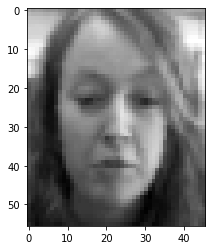

In [0]:
x = np.reshape(X_train[8], (46, 56))
plt.imshow(x.T, cmap='gist_gray')

In [0]:
def multi_pics(matrix):
  h, w = 5, 5
  nrows, ncols = 5, 8
  figsize = [20, 25]

  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

  for i, axi in enumerate(ax.flat):
      x = np.reshape(matrix[i], (46, 56))
      axi.imshow(x.T, cmap='gist_gray')
      rowid = i
      colid = i % ncols
  plt.tight_layout(True)
  plt.show()

# PCA-LDA 

#### 1. Compute the d-dimensional mean vectors

In [0]:
np.set_printoptions(precision=5)

mean_vectors = []
for i in range(0, 52):
  mean_vectors.append(np.mean(X_train[8*i:8*(i+1)], axis=0))
mean_vectors = np.array(mean_vectors)

#### 2. Compute the Scatter Matrices

In [0]:
def normalise(matrix):
  mm = []
  for m in matrix:
    mm.append(np.real(m))
  mat = np.array(mm)

  return normalize(mat, axis=0, norm='l1')

In [0]:
# within-class scatter

D = X_train.shape[1]  # 2576
S_W = np.zeros((D, D))
for cl, mv in zip(range(0, 52), mean_vectors):
  class_si_mat = np.zeros((D, D))
  for img in range(8*cl, 8*(cl+1)):
    row, mv = X_train[img].reshape(D,1), mv.reshape(D,1)
    class_si_mat += (row-mv).dot((row-mv).T)
  S_W += class_si_mat 

In [0]:
# between-class scatter

overall_mean = np.mean(X_train, axis=0)

S_B = np.zeros((D, D))
for mv in mean_vectors:
  n = 8   # size of the respective class
  overall_mean, mv = overall_mean.reshape(D,1), mv.reshape(D,1)   # make column vector
  S_B += n * (mv - overall_mean).dot((mv - overall_mean).T)

#### 3. Compute W_PCA

In [0]:
### VIP: COLUMNS ARE THE EIGENVECTORS!!
S_T = S_W + S_B
evals_PCA, W_PCA = np.linalg.eig(S_T)

In [0]:
# Take only the first M evecs
M_PCA = 300
Wm_PCA = W_PCA.T[:M_PCA]
Wm_PCA = Wm_PCA.T
Wm_PCA.shape

(2576, 300)

#### 4. Compute the PCA scatter matrices

In [0]:
S_B_PCA = Wm_PCA.T.dot(S_B).dot(Wm_PCA)
S_W_PCA = Wm_PCA.T.dot(S_W).dot(Wm_PCA)

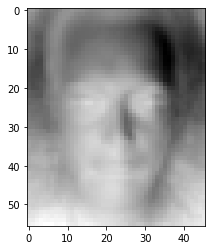

In [0]:
r = normalise(Wm_PCA)
x = np.reshape(r.T[0], (46, 56))
plt.imshow(x.T, cmap='gist_gray')

#### 5. Compute W_LDA

In [0]:
evals_LDA, W_LDA = np.linalg.eig(np.linalg.inv(S_W_PCA).dot(S_B_PCA))
W_LDA.shape

(300, 300)

#### 6. Compute optimal weights

##### Selecting linear discriminants for the new feature subspace

In [0]:
# Make a list of (eigenvalue, eigenvector) tuples
LDA_eig_pairs = [(np.abs(evals_LDA[i]), W_LDA[:,i]) for i in range(len(evals_LDA))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
LDA_eig_pairs = sorted(LDA_eig_pairs, key=lambda k: k[0], reverse=True)

Variance explained:



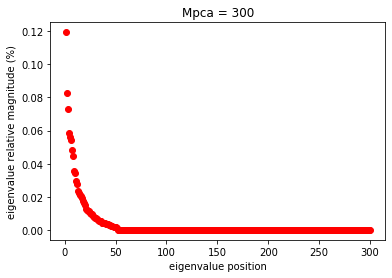

In [0]:
from pylab import *
from tikzplotlib import save as tikz_save

print('Variance explained:\n')
eigv_sum = sum(abs(evals_LDA))

x, y = [], []
for i,j in enumerate(LDA_eig_pairs):
    # print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))
    x.append(i+1)
    y.append(j[0]/eigv_sum)



plt.plot(x, y, 'ro')
plt.title('Mpca = {}'.format(M_PCA))
plt.xlabel('eigenvalue position')
plt.ylabel('eigenvalue relative magnitude (%)')
plt.show()

After sorting the eigenpairs by decreasing eigenvalues, it is now time to construct our k×d-dimensional eigenvector matrix W_LDA (here 416×51: based on the 51 most informative eigenpairs) and thereby reducing the initial 416-dimensional feature space into a 51-dimensional feature subspace.

In [0]:
M_LDA = 300
Wm_LDA = W_LDA[:M_LDA]

W_OPT_T = Wm_LDA.dot(Wm_PCA.T)
W_OPT = W_OPT_T.T
W_OPT.shape

(2576, 300)

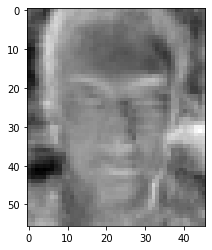

In [0]:
# FISHERFACE
x = np.reshape(normalise(W_OPT).T[0], (46, 56))
plt.imshow(x.T, cmap='gist_gray')

#### 7. Perform NN classification

In [0]:
W_OPT_N = normalise(W_OPT)
X_LDA = X_train.dot(W_OPT_N)
X_LDA.shape

(416, 300)

In [0]:
# Calculate predicted labels
Test_LDA = X_test.dot(W_OPT_N)

y_pred = []
for test in Test_LDA:
  min_e = float('inf')
  label = 0
  for i in range(X_LDA.shape[0]):
    error = np.linalg.norm(test-X_LDA[i])
    if error < min_e:
      min_e = error
      label = y_train[i][0]
  y_pred.append(label)

In [0]:
from sklearn.metrics import confusion_matrix

def cm(y_pred, y_actu=list(y_test.flatten())):
  cm = confusion_matrix(y_actu, y_pred)

  plt.matshow(cm, cmap = 'magma')
  plt.colorbar()
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

In [0]:
# print confusion matrix
cm(y_pred)

In [0]:
def acc(y_pred, y_actu=list(y_test.flatten())):
  correct_labels = 0
  for actu, pred in zip(y_actu, y_pred):
    correct_labels = correct_labels + 1 if actu == pred else correct_labels

  return correct_labels / len(y_actu) * 100

In [0]:
print(acc(y_pred))

58.65384615384615


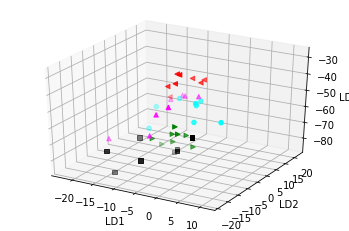

In [0]:
from mpl_toolkits import mplot3d

y = y_train.flatten()

def nn():
  fig = plt.figure()
  ax = fig.add_subplot( projection='3d')
  for label,marker,color in zip(
      range(1,6),('^', 's', 'o', '<', '>'),('magenta', 'black', 'cyan', 'red', 'green')):
      ax.scatter3D(xs=X_LDA.T[:][1].real[y == label],
                   ys=X_LDA.T[:][2].real[y == label],
                   zs=X_LDA.T[:][3].real[y == label],
                   marker=marker,
                   color=color,
                   )
  ax.set_xlabel('LD1')
  ax.set_ylabel('LD2')
  ax.set_zlabel('LD3')

  plt.show()

nn()

# PCA-LDA Ensemble

In [0]:
import random 
from collections import Counter

def PCA_LDA_E(total_models):

  X_models_LDA, Test_models_LDA = [], []

  for i in range(total_models):
    # define de random parameters
    M_PCA = random.randint(200, 370)
    M_LDA = random.randint(200, 370)
    
    # calculate the PCA weights
    Wm_PCA = W_PCA.T[:M_PCA]
    Wm_PCA = Wm_PCA.T

    # calculate the PCA scatter matrices
    S_B_PCA = Wm_PCA.T.dot(S_B).dot(Wm_PCA)
    S_W_PCA = Wm_PCA.T.dot(S_W).dot(Wm_PCA)

    # calculate the LDA weights 
    evals_LDA, W_LDA = np.linalg.eig(np.linalg.inv(S_W_PCA).dot(S_B_PCA))
    Wm_LDA = W_LDA[:M_LDA]

    # calculate the optimal weights
    W_OPT_T = Wm_LDA.dot(Wm_PCA.T)
    W_OPT = W_OPT_T.T
    W_OPT_N = normalise(W_OPT)

    # add the projections of training and testing images
    X_models_LDA.append(X_train.dot(W_OPT_N))
    Test_models_LDA.append(X_test.dot(W_OPT_N))


  # Calculate weighted label 
  total_predictions = []
  for X_LDA, Test_LDA in zip(X_models_LDA, Test_models_LDA):
    y_pred = []
    for test in Test_LDA:
      min_e = float('inf')
      label = 0
      for i in range(X_LDA.shape[0]):
        error = np.linalg.norm(test-X_LDA[i])
        if error < min_e:
          min_e = error
          label = y_train[i][0]
      y_pred.append(label)
    total_predictions.append(y_pred)

  # find the most voted label
  weighted_prediction = []
  for label in np.array(total_predictions).T:
    mode = Counter(label)
    modes = sorted(label, key=lambda k: -mode[k])
    weighted_prediction.append(modes[0])

  return weighted_prediction, total_predictions

In [0]:
start = time()
y_mode, y_total = PCA_LDA_E(total_models=50)
end = time()

In [0]:
model_acc = []
for y_pred in y_total:
  model_acc.append(acc(y_pred))
model_acc_avg = np.average(model_acc)